In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 2


# Autoencoders for Data Certification

In [2]:
# Imports...

import getpass
import h5py
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model, load_model

Using TensorFlow backend.


In [3]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

## Load the dataset

In [4]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

In [5]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_directory = "./"
model_directory = "./models/"
selectPD = 11

In [6]:
# Get permission to access EOS (Insert your NICE password)

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [7]:
with open("feature_names.txt", "r") as features:
    feature_names = []
    for feature in eval(features.read()):
        for i in range(1, 8):
            feature_names.append("%s_%s" % (feature, i))
            
feature_names.extend(["run", "lumi", "inst_lumi", "_foo", "_bar", "_baz"])

In [8]:
# Load good and bad jets

def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

files = get_file_list(data_directory, PDs, selectPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, selectPD, "signal", ".h5")
data = pd.DataFrame(get_data(files), columns=feature_names)

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [9]:
data["run"] = data["run"].astype(int)
data["lumi"] = data["lumi"].astype(int)

# Drop unnecessary meta data
data.drop(["_foo", "_bar", "_baz"], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)

In [10]:
# Apply labels
label_file = "%s%s.json" % (label_directory, PDs[selectPD])
label_json = json.load(open(label_file))

def json_checker(json, orig_runid, orig_lumid):
    try:
        for i in json[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(label_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [11]:
print("Number of anomalies: ", len(data[data["label"] == 1]))
print("Number of inliers: ", len(data[data["label"] == 0]))

Number of anomalies:  2377
Number of inliers:  161307


## Training

In [12]:
# Sparse autoencoder
input_dim = 2806

input_layer = Input(shape=(input_dim, ), name="InputEncoder1")
encoder = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoder = PReLU()(encoder)
encoder = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder)
encoder = PReLU()(encoder)
encoder = Dense(16, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder)
encoder = PReLU()(encoder)
decoder = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder)
decoder = PReLU()(decoder)
decoder = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(decoder)
decoder = PReLU()(decoder)
decoder = Dense(input_dim, activation='tanh', name='OutputDecoder')(decoder)

sparse_autoencoder0 = Model(inputs=input_layer, outputs=decoder)

# Sparse autoencoder
input_layer1 = Input(shape=(input_dim, ), name="InputEncoder2")
encoder1 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer1)
encoder1 = PReLU()(encoder1)
encoder1 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder1)
encoder1 = PReLU()(encoder1)
encoder1 = Dense(16, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder1)
encoder1 = PReLU()(encoder1)
decoder1 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder1)
decoder1 = PReLU()(decoder1)
decoder1 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(decoder1)
decoder1 = PReLU()(decoder1)
decoder1 = Dense(input_dim, activation='tanh', name='OutputDecoder')(decoder1)

sparse_autoencoder1 = Model(inputs=input_layer1, outputs=decoder1)

# Sparse autoencoder
input_layer2 = Input(shape=(input_dim, ), name="InputEncoder3")
encoder2 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer2)
encoder2 = PReLU()(encoder2)
encoder2 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder2)
encoder2 = PReLU()(encoder2)
encoder2 = Dense(16, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder2)
encoder2 = PReLU()(encoder2)
decoder2 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder2)
decoder2 = PReLU()(decoder2)
decoder2 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(decoder2)
decoder2 = PReLU()(decoder2)
decoder2 = Dense(input_dim, activation='tanh', name='OutputDecoder')(decoder2)

sparse_autoencoder2 = Model(inputs=input_layer2, outputs=decoder2)


# Sparse autoencoder
input_layer3 = Input(shape=(input_dim, ), name="InputEncoder4")
encoder3 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer3)
encoder3 = PReLU()(encoder3)
encoder3 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder3)
encoder3 = PReLU()(encoder3)
encoder3 = Dense(16, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder3)
encoder3 = PReLU()(encoder3)
decoder3 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder3)
decoder3 = PReLU()(decoder3)
decoder3 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(decoder3)
decoder3 = PReLU()(decoder3)
decoder3 = Dense(input_dim, activation='tanh', name='OutputDecoder')(decoder3)

sparse_autoencoder3 = Model(inputs=input_layer3, outputs=decoder3)

# Sparse autoencoder
input_layer4 = Input(shape=(input_dim, ), name="InputEncoder5")
encoder4 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer4)
encoder4 = PReLU()(encoder4)
encoder4 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder4)
encoder4 = PReLU()(encoder4)
encoder4 = Dense(16, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder4)
encoder4 = PReLU()(encoder4)
decoder4 = Dense(64, kernel_regularizer=keras.regularizers.l1(10e-5))(encoder4)
decoder4 = PReLU()(decoder4)
decoder4 = Dense(128, kernel_regularizer=keras.regularizers.l1(10e-5))(decoder4)
decoder4 = PReLU()(decoder4)
decoder4 = Dense(input_dim, activation='tanh', name='OutputDecoder')(decoder4)

sparse_autoencoder4 = Model(inputs=input_layer4, outputs=decoder4)

In [13]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][300])
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

In [21]:
from keras import backend as K
import tensorflow as tf

def custom_error(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=100, sorted=True)
    return K.mean(top_values, axis=-1)

Dataset fraction: 0.2
Preparing dataset...
Train test split...
Training autoencoder
Epoch 00723: early stopping


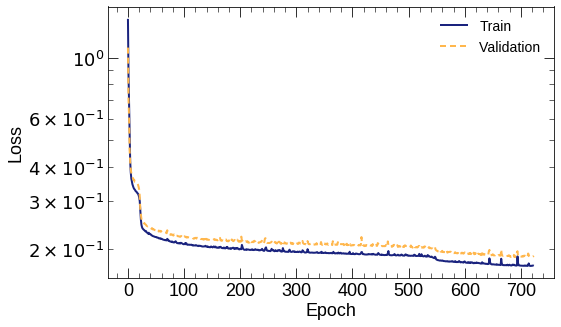

Dataset fraction: 0.4
Preparing dataset...
Train test split...
Training autoencoder
Epoch 00554: early stopping


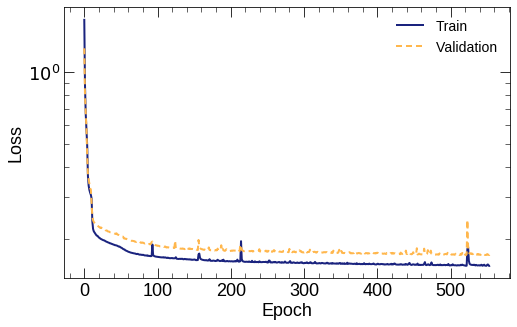

Dataset fraction: 0.6
Preparing dataset...
Train test split...
Training autoencoder
Epoch 00554: early stopping


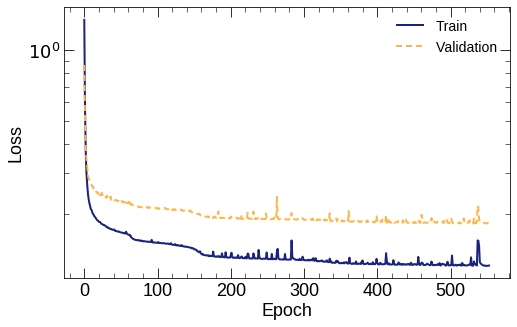

Dataset fraction: 0.8
Preparing dataset...
Train test split...
Training autoencoder
Epoch 00381: early stopping


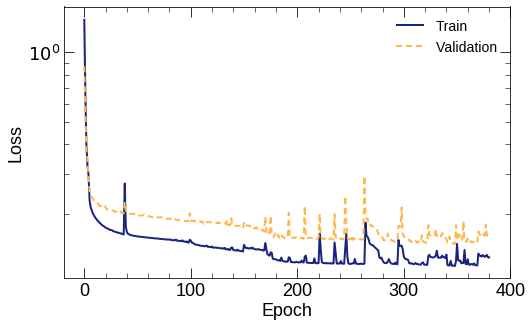

Dataset fraction: 1.0
Preparing dataset...
Train test split...
Training autoencoder
Epoch 00301: early stopping


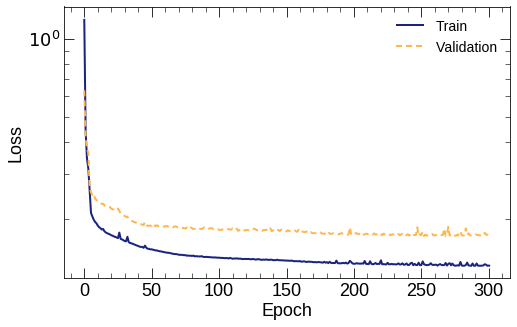

In [16]:
for dataset_fraction, autoencoder in zip(np.array(range(2, 11, 2)) / 10, [sparse_autoencoder0,
                                                            sparse_autoencoder1,
                                                            sparse_autoencoder2,
                                                            sparse_autoencoder3,sparse_autoencoder4]):
    print("Dataset fraction: %s" % dataset_fraction)
    print("Preparing dataset...")
    split = int(dataset_fraction*len(data))    
    dataset = data.iloc[:split].copy()

    print("Train test split...")
    split = int(0.8*len(dataset))
    df_train = dataset.iloc[:split].copy()
    X_train = df_train.iloc[:, 0:2806]
    y_train = df_train["label"]
    X_train = X_train[y_train == 0]
    
    print("Training autoencoder")
    
    model_name = "SAE_Loss%s" % int(10*dataset_fraction)
    
    scaler_ae = MinMaxScaler(feature_range=(-1,1))
    scaler_ae.fit(X_train.values)
    X_train = scaler_ae.transform(X_train.values)
    early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

    autoencoder.compile(optimizer=keras.optimizers.Adam(),
                               loss=custom_error)

    checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    history = autoencoder.fit(X_train,
                              X_train,
                              epochs=2048,
                              batch_size=1024,
                              shuffle=True,
                              validation_split=0.25,
                              verbose=0,
                              callbacks=[early_stopper, checkpoint_callback]).history
    
    plot_loss(history, "")

## Evaluation (just AE)

In [ ]:
# Reload saved model

autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [ ]:
# Run predictions

predictions = autoencoder.predict(X_test)

In [ ]:
legend = [{"name": 'pf_jets', "start": 0, "end": 777, "color": color_palette["Indigo"][100]},
          {"name": 'cal_jet_mets', "start": 778, "end": 946, "color": color_palette["Indigo"][300]},
          {"name": 'pho', "start": 947, "end": 1283, "color": color_palette["Indigo"][500]},
          {"name": 'muons', "start": 1284, "end": 1788, "color": color_palette["Indigo"][700]},
          {"name": 'pf_jets2', "start": 1789, "end": 1894, "color": color_palette["Indigo"][900]},
          {"name": 'pf_mets', "start": 1895, "end": 1923, "color": color_palette["Indigo"][200]},
          {"name": 'nvtx', "start": 1924, "end": 1925, "color": color_palette["Indigo"][400]},
          {"name": 'cal_jet_mets2', "start": 1925, "end": 2037, "color": color_palette["Indigo"][600]},
          {"name": 'sc', "start": 2038, "end": 2129, "color": color_palette["Indigo"][800]},
          {"name": 'cc', "start": 2130, "end": 2172, "color": color_palette["Orange"][100]},
          {"name": 'pho2', "start": 2173, "end": 2369, "color": color_palette["Orange"][300]},
          {"name": 'muons2', "start": 2370, "end": 2476, "color": color_palette["Orange"][500]},
          {"name": 'ebs', "start": 2497, "end": 2707, "color": color_palette["Orange"][700]},
          {"name": 'hbhef', "start": 2708, "end": 2771, "color": color_palette["Orange"][900]},
          {"name": 'presh', "start": 2772, "end": 2810, "color": color_palette["Orange"][400]}]

In [ ]:
# Get error

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

#scores = get_error_df(X_test, predictions, mode="perobj")

In [ ]:
#Make ROC_curve

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

def get_roc_curve(label, score, legend_label):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    fpr, tpr, thresholds = roc_curve(label, score)
    roc_auc = round(auc(fpr, tpr), 3)
    
    plt.plot(fpr,
             tpr,
             linewidth=3,
             color=color_palette["Indigo"][400],
             linestyle=line_styles[0],
             label=("%s, AUC: %s" % (legend_label, roc_auc)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();
    
get_roc_curve(y_test.values, scores, "Simple autoencoder")

In [ ]:
# Plot lumi vs error

fig, ax = plt.subplots()

plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
         scores[y_test == 0],
         color=color_palette["Orange"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
         scores[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("Lumisection #")
plt.show();

In [ ]:
# Choose lumisection
INDEX = 100    

reconstruction = abs(X_test[INDEX] - predictions[INDEX])
features = [i for i in range(reconstruction.shape[0])]

for l in legend:
    plt.plot(features[l["start"]:l["end"]],
             reconstruction[l["start"]:l["end"]],
             color=l["color"])

plt.ylabel("Absolute Error")
plt.xticks([l["start"] for l in legend], [l["name"] for l in legend], rotation='vertical')
plt.show();

## Evaluation

In [17]:
legend = [{"name": 'pf_jets', "start": 0, "end": 777, "color": color_palette["Indigo"][100]},
          {"name": 'cal_jet_mets', "start": 778, "end": 946, "color": color_palette["Indigo"][300]},
          {"name": 'pho', "start": 947, "end": 1283, "color": color_palette["Indigo"][500]},
          {"name": 'muons', "start": 1284, "end": 1788, "color": color_palette["Indigo"][700]},
          {"name": 'pf_jets2', "start": 1789, "end": 1894, "color": color_palette["Indigo"][900]},
          {"name": 'pf_mets', "start": 1895, "end": 1923, "color": color_palette["Indigo"][200]},
          {"name": 'nvtx', "start": 1924, "end": 1925, "color": color_palette["Indigo"][400]},
          {"name": 'cal_jet_mets2', "start": 1925, "end": 2037, "color": color_palette["Indigo"][600]},
          {"name": 'sc', "start": 2038, "end": 2129, "color": color_palette["Indigo"][800]},
          {"name": 'cc', "start": 2130, "end": 2172, "color": color_palette["Orange"][100]},
          {"name": 'pho2', "start": 2173, "end": 2369, "color": color_palette["Orange"][300]},
          {"name": 'muons2', "start": 2370, "end": 2476, "color": color_palette["Orange"][500]},
          {"name": 'ebs', "start": 2497, "end": 2707, "color": color_palette["Orange"][700]},
          {"name": 'hbhef', "start": 2708, "end": 2771, "color": color_palette["Orange"][900]},
          {"name": 'presh', "start": 2772, "end": 2810, "color": color_palette["Orange"][400]}]

In [18]:
# Get error

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

In [19]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

def get_roc_curve(classifiers, truth):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    color = 900
    color_decrement = 400
    
    for scores, legend_label in classifiers:
        fpr, tpr, thresholds = roc_curve(truth, scores)
        roc_auc = round(auc(fpr, tpr), 3)
        plt.plot(fpr,
                 tpr,
                 color=color_palette["Indigo"][color],
                 linestyle=line_styles[0],
                 label=("%s, AUC: %s" % (legend_label, roc_auc)))
        color = color - color_decrement

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (1-TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();

Preparing dataset...
Train test split...
Number of inliers in test set: 6529
Number of anomalies in the test set: 19
Training Isolation Forest
Training Random Forest
Autoencoder
Dataset fraction: 0.2


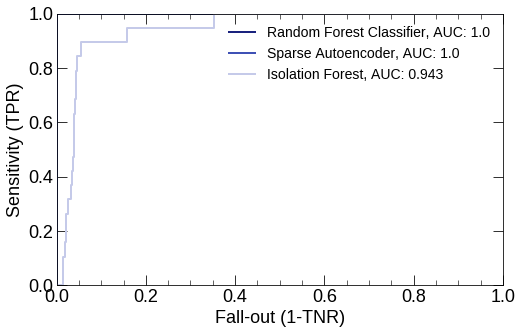

Preparing dataset...
Train test split...
Number of inliers in test set: 13074
Number of anomalies in the test set: 21
Training Isolation Forest
Training Random Forest
Autoencoder
Dataset fraction: 0.4


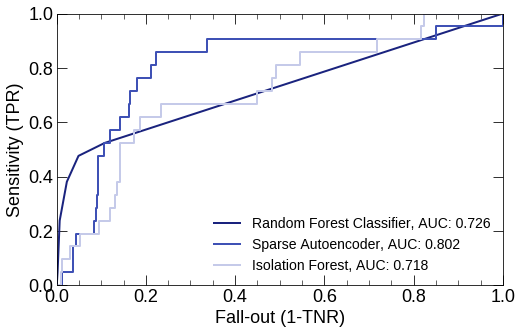

Preparing dataset...
Train test split...
Number of inliers in test set: 19504
Number of anomalies in the test set: 138
Training Isolation Forest
Training Random Forest
Autoencoder
Dataset fraction: 0.6


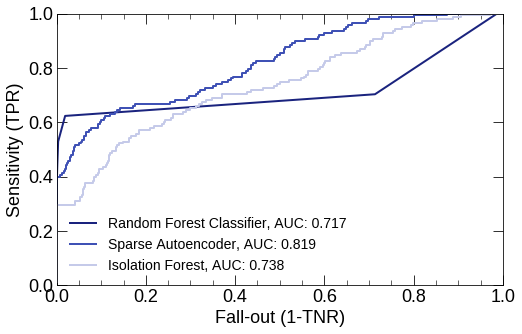

Preparing dataset...
Train test split...
Number of inliers in test set: 25473
Number of anomalies in the test set: 717
Training Isolation Forest
Training Random Forest
Autoencoder
Dataset fraction: 0.8


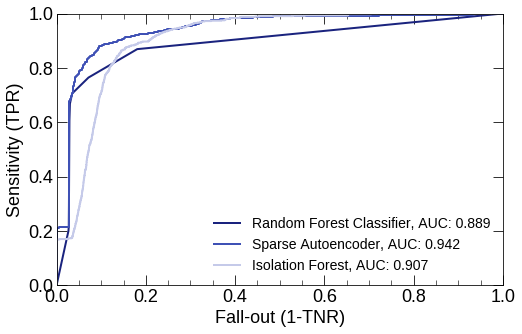

Preparing dataset...
Train test split...
Number of inliers in test set: 32078
Number of anomalies in the test set: 659
Training Isolation Forest
Training Random Forest
Autoencoder
Dataset fraction: 1.0


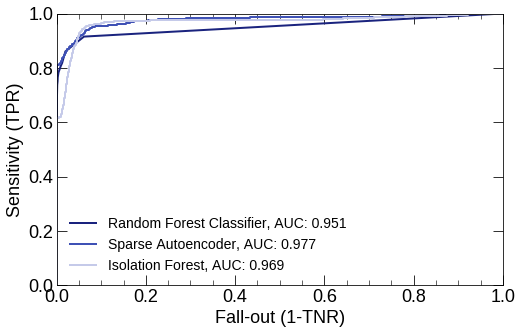

In [23]:
for dataset_fraction in np.array(range(2, 11, 2)) / 10:
    print("Preparing dataset...")
    split = int(dataset_fraction*len(data))    
    dataset = data.iloc[:split].copy()

    print("Train test split...")
    split = int(0.8*len(dataset))
    df_train = dataset.iloc[:split].copy()
    df_test = dataset.iloc[split:].copy()
    X_train = df_train.iloc[:, 0:2806]
    y_train = df_train["label"]
    X_test = df_test.iloc[:, 0:2806]
    print("Number of inliers in test set: %s" % sum((df_test.label == 0).values))
    print("Number of anomalies in the test set: %s" % sum((df_test.label == 1).values))
       
    print("Training Isolation Forest")
    scaler_if = MinMaxScaler(feature_range=(-1,1))
    scaler_if.fit(X_train.values)
    ifclf = IsolationForest(random_state=42)
    ifclf.fit(scaler_if.transform(X_test.values));
    df_test["if_score"] = -ifclf.decision_function(scaler_if.transform(X_test.values))
    
    print("Training Random Forest")
    scaler_rf = StandardScaler()
    scaler_rf.fit(X_train.values)
    rfc = RandomForestClassifier()
    rfc.fit(scaler_rf.transform(X_train.values), y_train);
    df_test["rf_score"] = rfc.predict_proba(scaler_rf.transform(X_test.values))[:,1]
    
    print("Autoencoder")
    model_name = "SAE_Loss%s" % int(10*dataset_fraction)
    scaler_ae = MinMaxScaler(feature_range=(-1,1))
    scaler_ae.fit(X_train[y_train == 0].values)
    autoencoder = load_model("%s%s.h5" % (model_directory, model_name),
                             custom_objects={'custom_error': custom_error})
    predictions = autoencoder.predict(scaler_ae.transform(X_test.values))
    df_test["ae_score"] = get_error_df(scaler_ae.transform(X_test.values),
                                       predictions,
                                       mode="topn")
    
    print("Dataset fraction: %s" % dataset_fraction)
    get_roc_curve([(df_test["rf_score"].values, "Random Forest Classifier"),
                   (df_test["ae_score"].values, "Sparse Autoencoder"),
                   (df_test["if_score"].values, "Isolation Forest")],
                  df_test["label"].values)